Original shape (1080, 1920)


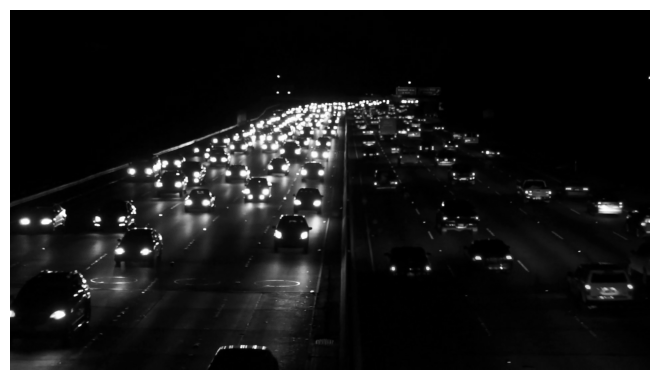

Decimated shape (216, 384)


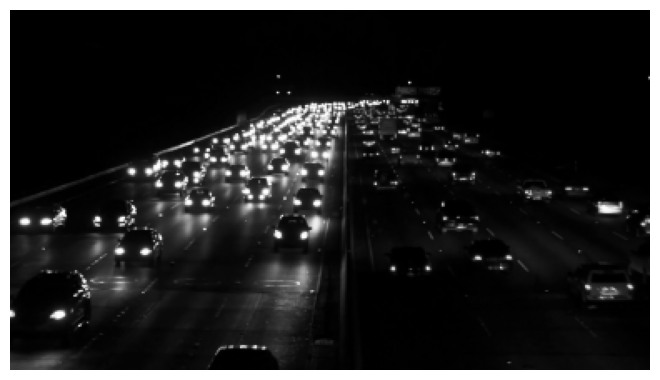

In [27]:
import sys
sys.path.append('../src')

from illustrate import get_image, plot_image
from transform import convert_to_grayscale

test_image_url = 'https://dm0qx8t0i9gc9.cloudfront.net/thumbnails/video/Vd3bj2jPe/night-traffic-on-autobahn-night-city-road_vkqxllatl_thumbnail-1080_01.png'

image = get_image(test_image_url)
grayscale_image = convert_to_grayscale(image)

def decimate(image, factor = 2):
    if factor <= 0:
        raise ValueError("Decimation factor should be a positive integer.")

    height = image.shape[0] // factor
    width = image.shape[1] // factor
    reshaped_image = image[:height * factor, :width * factor].reshape((height, factor, width, factor))
    decimated_image = reshaped_image.mean(axis=(1, 3))

    return decimated_image

decimated = decimate(grayscale_image, factor = 5)

print(f"Original shape {grayscale_image.shape}")
plot_image(grayscale_image)
print(f"Decimated shape {decimated.shape}")
plot_image(decimated)

Original shape (1080, 1920), expanded shape (1080, 1920)


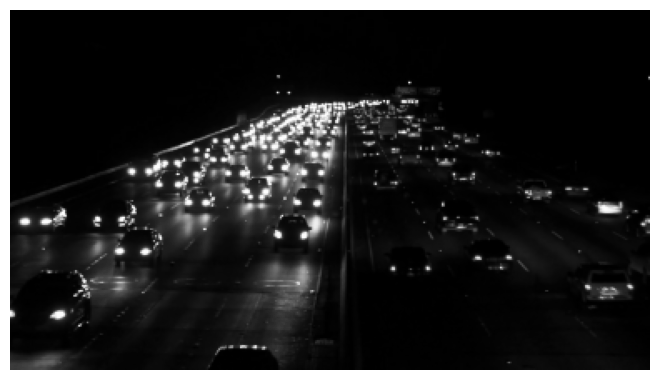

In [28]:
import numpy as np

def expand(image, factor = 2):
    if factor <= 0:
        raise ValueError("Expansion factor should be a positive integer.")

    new_height = image.shape[0] * factor
    new_width = image.shape[1] * factor
    expanded_image = np.zeros((new_height, new_width), dtype=image.dtype)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            expanded_image[i * factor:(i + 1) * factor, j * factor:(j + 1) * factor] = image[i, j]

    return expanded_image

expanded = expand(decimated, factor = 5)

print(f"Original shape {grayscale_image.shape}, expanded shape {expanded.shape}")
plot_image(expanded)


Residuals shape (1080, 1920)


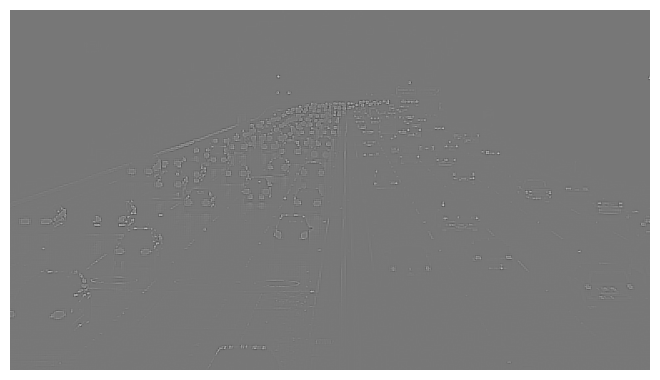

In [29]:
def residual(original_image, upsampled_image):
    if original_image.shape != upsampled_image.shape:
        raise ValueError("Original and upsampled images must have the same dimensions.")

    residuals = original_image - upsampled_image

    return residuals

residuals = residual(grayscale_image, expanded)

print(f"Residuals shape {residuals.shape}")
plot_image(residuals)

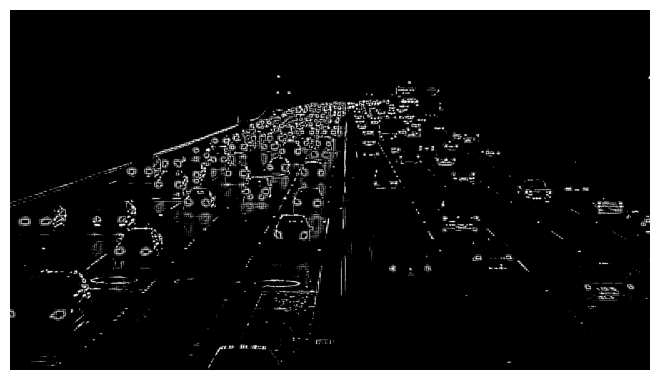

In [30]:
import numpy as np

def threshold_image(image, threshold_value):
    return np.where(image > threshold_value, 255, 0)

threshold = 10

plot_image(threshold_image((residuals), threshold))

Factor = 2


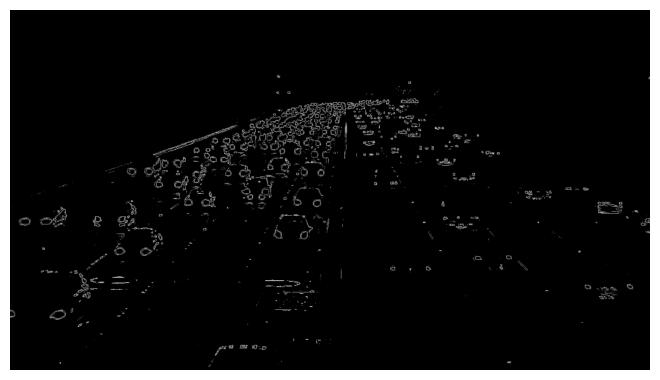

Factor = 3


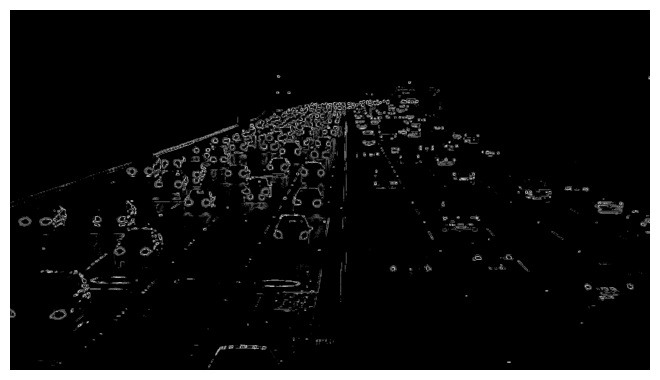

Factor = 4


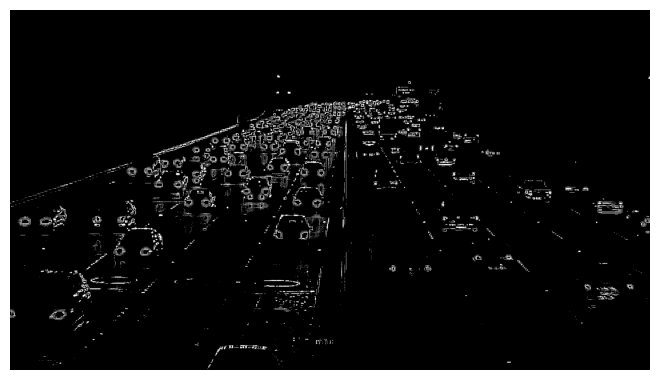

Factor = 5


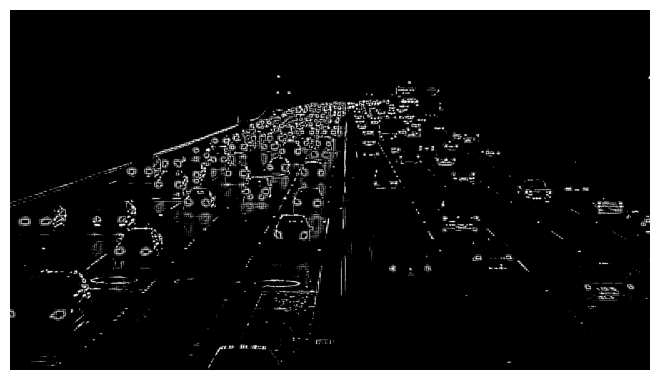

Factor = 6


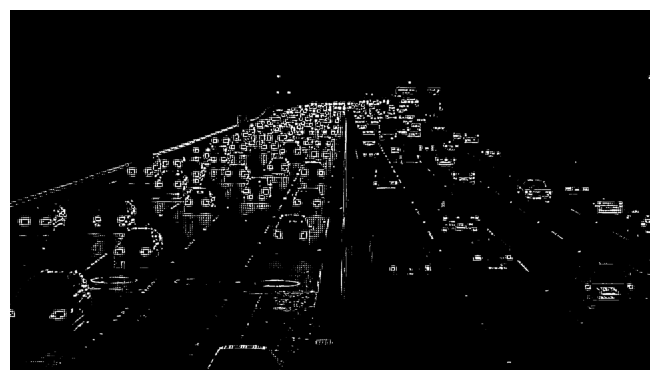

Factor = 8


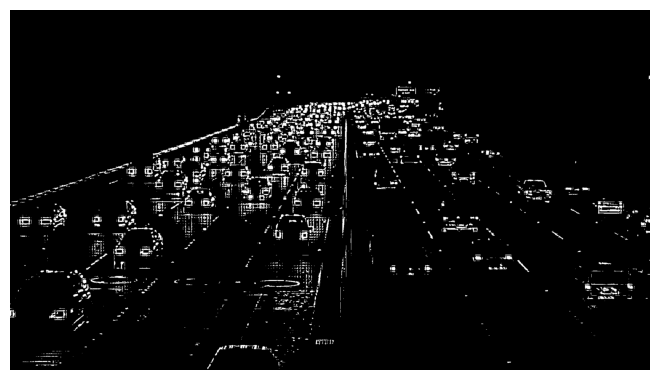

Factor = 10


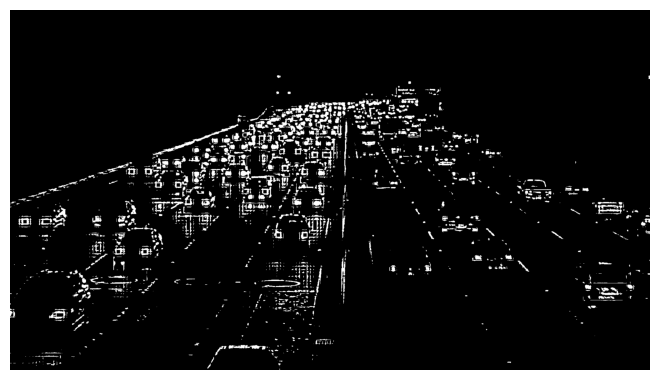

Factor = 12


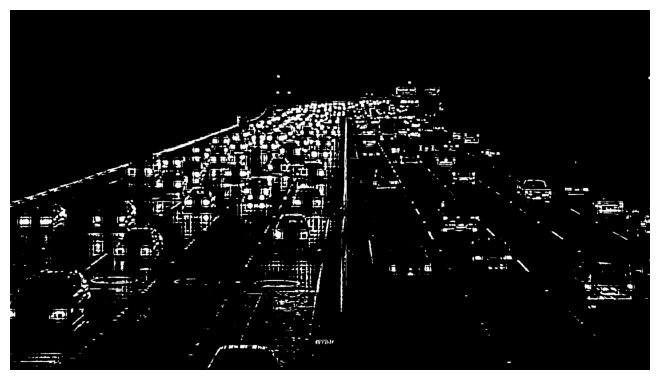

Factor = 15


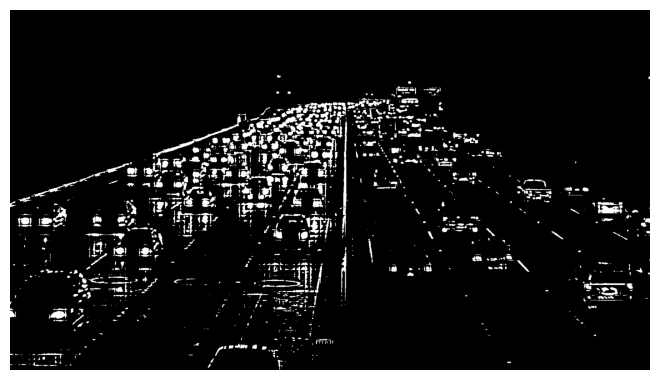

In [31]:
# Decimation levels that are applicable to the input image
levels = [x for x in range(2,20) if grayscale_image.shape[0] % x == 0 and grayscale_image.shape[1] % x == 0]
threshold = 10

for level in levels:
    decimated = decimate(grayscale_image, factor= level)
    expanded = expand(decimated, factor= level)
    residuals = (residual(grayscale_image, expanded))
    output = threshold_image((residuals), threshold)
    print(f"Factor = {level}")
    plot_image(output)

Gaussian pyramid [4 levels]


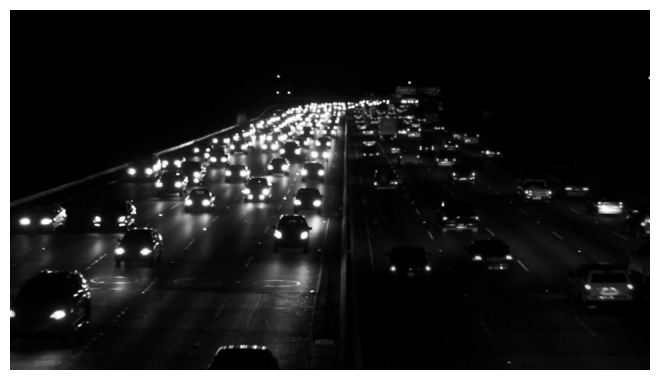

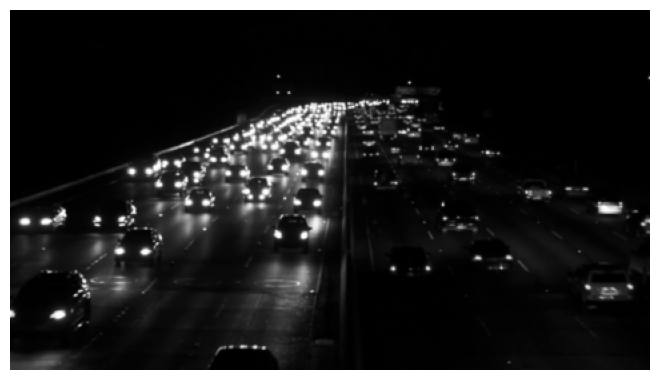

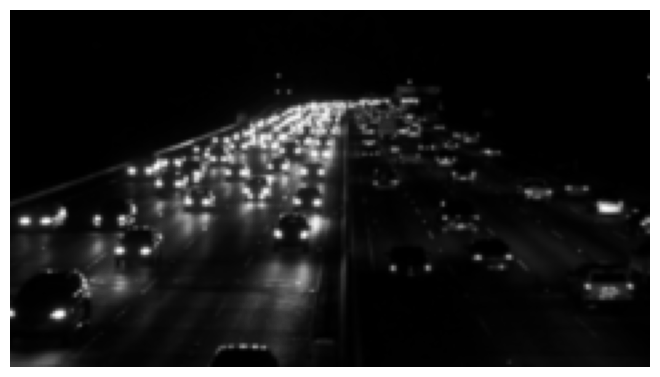

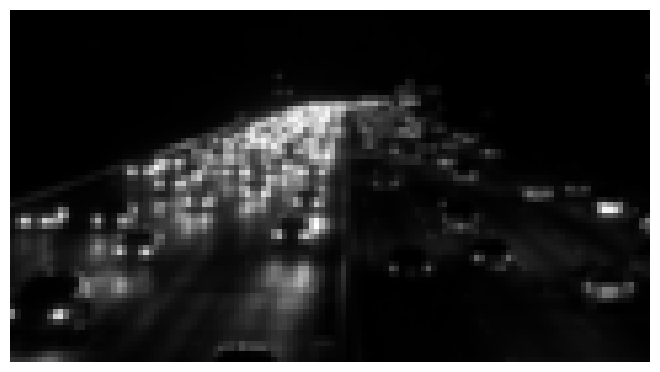

In [32]:
import sys
sys.path.append('../src')

from filters import Gaussian, Sobel

import math
import sys

class Pyramid:
    def __init__(self, levels, filter, kernel_size = 3):
        self.levels = levels
        if filter != None:
            self.filter_type = getattr(sys.modules[__name__], filter)
            self.filter = self.filter_type(kernel_size)
        else:
            self.filter = None
    
    @property
    def filter_name(self):
        return self.filter_type.__name__ if self.filter else 'Unfiltered'

    def __str__(self):
        return f"{self.filter_name} pyramid [{self.levels} levels]"
    
    def _decompose(self, image):
        if len(image.shape) == 3:
            grayscale_image = convert_to_grayscale(image)
        else:
            grayscale_image = image
        
        sample = grayscale_image
        if self.filter != None:
            filtered = self.filter.apply(grayscale_image)
            sample = filtered
            
            if self.filter_name == 'Sobel':
                sample = filtered[0]

        decimated = decimate(sample)
        expanded = expand(decimated)
        residuals = residual(sample, expanded)

        return decimated, residuals

    def extract(self, image):
        self._samples = []
        self._residuals = []

        target = image
        for _ in range(0, self.levels):
            dec, res = self._decompose(target)
            if dec.shape[0] % 2 != 0 or dec.shape[1] % 2 != 0:
                dec = dec[0:(int)(math.floor(dec.shape[0] / 2) * 2), 0:(int)(math.floor(dec.shape[1] / 2) * 2)]
            self._samples.append(dec)
            self._residuals.append(res)
            target = dec

    @property
    def samples(self):
        return self._samples
    
    @property
    def residuals(self):
        return self._residuals

# representation = Pyramid(levels = 4, filter = 'Sobel', kernel_size=3)
representation = Pyramid(levels=4, filter='Gaussian', kernel_size=3)
print(representation)
representation.extract(grayscale_image)
for feature in representation.samples:
    plot_image(feature)


In [33]:
def split_into_blocks(image, block_shape):
    image_height, image_width = image.shape[:2]
    block_height, block_width = block_shape

    num_blocks_vertical = image_height // block_height
    num_blocks_horizontal = image_width // block_width

    blocks = []

    # Iterate through the blocks and append them to the list
    for i in range(num_blocks_vertical):
        for j in range(num_blocks_horizontal):
            block = image[i * block_height: (i + 1) * block_height, 
                          j * block_width: (j + 1) * block_width]
            blocks.append(block)

    return np.array(blocks)

def feature_stack(image, representation, block_shape):

    representation.extract(image)
    feature_set = []
    for level, sample in enumerate(representation.samples):
        blocks = split_into_blocks(sample, block_shape)
        print(f"Level {level} got {len(blocks)} subsamples")
        for index, feature in enumerate(blocks):
            x_max = sample.shape[0] / block_shape[0]
            y_max = sample.shape[1] / block_shape[1]
            x0 = round(index / x_max)
            y0 = round(index % y_max)
            position = (level, x0, y0)
            feature_set.append((feature, position))

    return feature_set


representation = Pyramid(levels=4, filter=None)
# representation = Pyramid(levels = 4, filter = 'Sobel', kernel_size=3)
block_shape = (33, 60)

feature_set = feature_stack(grayscale_image, representation, block_shape)
print(f'Got total of {len(feature_set)} subsamples')


Level 0 got 256 subsamples
Level 1 got 64 subsamples
Level 2 got 16 subsamples
Level 3 got 4 subsamples
Got total of 340 subsamples



Level 1 resolution


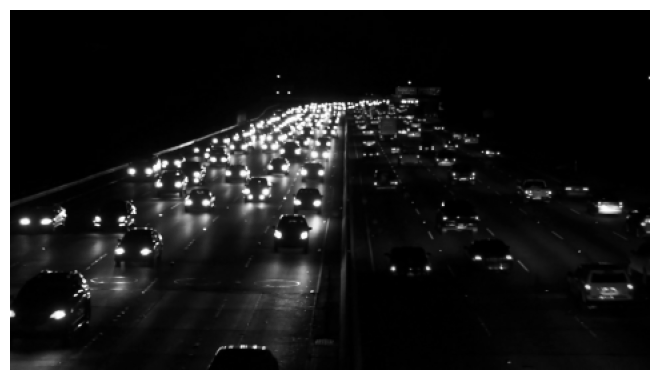

Selected feature


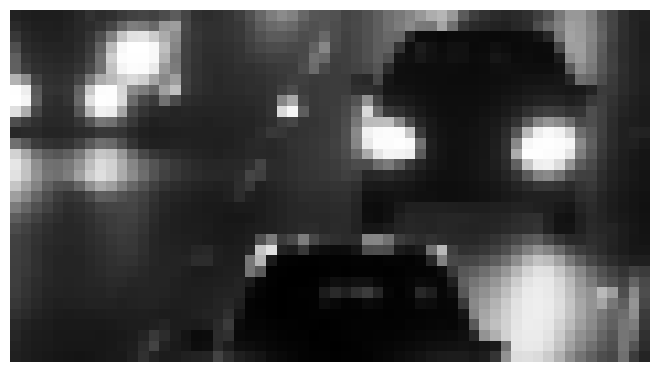

Selected feature position inside level 1 representation
[132, 180, 165, 240]


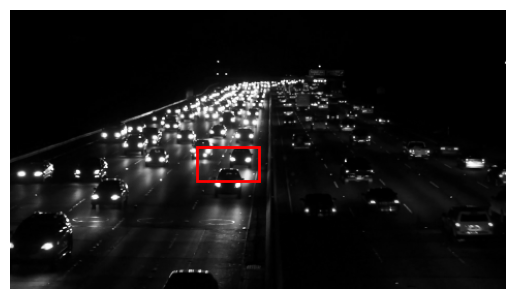

In [34]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def draw_rectangle(raw_image, rectangle_coords):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the raw image
    ax.imshow(raw_image, cmap='gray')

    # Create a rectangle patch
    rect = patches.Rectangle((rectangle_coords[1], rectangle_coords[0]), 
                             rectangle_coords[3] - rectangle_coords[1],
                             rectangle_coords[2] - rectangle_coords[0], 
                             linewidth=2, edgecolor='red', facecolor='none')

    # Add the rectangle to the plot
    ax.add_patch(rect)
    ax.axis('off')
    # Show the plot
    plt.show()

# Extract feature from level 1, center
print("\nLevel 1 resolution")
plot_image(representation.samples[1])

level_0_num_features = 256
selected_feature_index = 35

print('Selected feature')
selected_feature = feature_set[level_0_num_features + selected_feature_index]
plot_image(selected_feature[0])

print('Selected feature position inside level 1 representation')
_, feature_x, feature_y = selected_feature[1]
rectangle_coordinates = [
                         feature_x * block_shape[0],        #x0
                         feature_y * block_shape[1],        #y0
                         (feature_x + 1) * block_shape[0],  #x1
                         (feature_y + 1) * block_shape[1],  #y1
                        ]
print(rectangle_coordinates)

draw_rectangle(representation.samples[1], rectangle_coordinates)